<a href="https://colab.research.google.com/github/Hashan1999/Pig-Weight-Estimation/blob/main/Copy_of_Pig_Weight_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # choose pig_dataset.zip


Saving pig_datasetv4.zip to pig_datasetv4.zip


In [ ]:
import zipfile, os

zip_path = "pig_datasetv4.zip"   # if that is the name
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")

base_dir = "/content/pig_dataset"
print("Base dir:", base_dir, "exists:", os.path.isdir(base_dir))


Base dir: /content/pig_dataset exists: True


In [ ]:
!pip install opencv-python-headless scikit-learn pandas matplotlib


In [ ]:
import os
import pandas as pd

base_dir = "/content/pig_dataset"
labels_path = os.path.join(base_dir, "labels.csv")

df_labels = pd.read_csv(labels_path)

# 🔧 FIX WINDOWS PATHS → LINUX PATHS
df_labels["rgb_path"] = df_labels["rgb_path"].str.replace("\\", "/", regex=False)
df_labels["mask_path"] = df_labels["mask_path"].str.replace("\\", "/", regex=False)

df_labels.head()



,rgb_path,mask_path,target_weight_kg,base_weight_kg,scale,distance_m,angle_deg
0,60kg/rgb/pig_w60kg_n00.png,60kg/mask/pig_w60kg_n00_mask.png,60,93.6,0.862234,3.0,86.176266
1,60kg/rgb/pig_w60kg_n01.png,60kg/mask/pig_w60kg_n01_mask.png,60,93.6,0.862234,3.0,89.971173
2,60kg/rgb/pig_w60kg_n02.png,60kg/mask/pig_w60kg_n02_mask.png,60,93.6,0.862234,3.0,91.788375
3,60kg/rgb/pig_w60kg_n03.png,60kg/mask/pig_w60kg_n03_mask.png,60,93.6,0.862234,3.0,85.195446
4,60kg/rgb/pig_w60kg_n04.png,60kg/mask/pig_w60kg_n04_mask.png,60,93.6,0.862234,3.0,89.421259


In [ ]:
row = df_labels.sample(1).iloc[0]

rgb_path = os.path.join(base_dir, row["rgb_path"])
mask_path = os.path.join(base_dir, row["mask_path"])

print("RGB path:", rgb_path)
print("Mask path:", mask_path)

print("RGB exists?", os.path.exists(rgb_path))
print("Mask exists?", os.path.exists(mask_path))


RGB path: /content/pig_dataset/120kg/rgb/pig_w120kg_n09.png
Mask path: /content/pig_dataset/120kg/mask/pig_w120kg_n09_mask.png
RGB exists? True
Mask exists? True


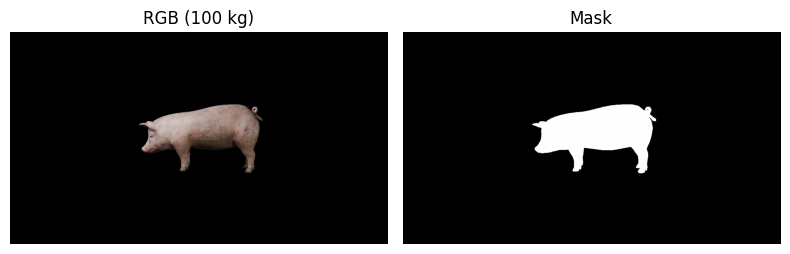

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# pick one row
row = df_labels.sample(1).iloc[0]

# Fix path separators: replace backslashes with forward slashes
rgb_path = os.path.join(base_dir, row["rgb_path"].replace("\\", "/"))
mask_path = os.path.join(base_dir, row["mask_path"].replace("\\", "/"))

rgb = cv2.imread(rgb_path)
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"RGB ({row['target_weight_kg']} kg)")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import cv2
import pandas as pd
import os

rows = []

for _, row in df_labels.iterrows():

    mask_path = os.path.join(base_dir, row["mask_path"])

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print("Could not read:", mask_path)
        continue

    # Threshold to ensure binary mask:
    _, binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # Pixel area (pig size in image)
    area_px = np.count_nonzero(binary)
    if area_px == 0:
        print("Empty mask:", mask_path)
        continue

    # Bounding box (tight box around pig)
    ys, xs = np.where(binary > 0)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    width_px  = x_max - x_min + 1
    height_px = y_max - y_min + 1

    aspect_ratio = width_px / height_px

    rows.append({
        "rgb_path": row["rgb_path"],
        "mask_path": row["mask_path"],
        "target_weight_kg": float(row["target_weight_kg"]),
        "area_px": area_px,
        "width_px": width_px,
        "height_px": height_px,
        "aspect_ratio": aspect_ratio,
    })

df = pd.DataFrame(rows)
df.head()


,rgb_path,mask_path,target_weight_kg,area_px,width_px,height_px,aspect_ratio
0,60kg/rgb/pig_w60kg_n00.png,60kg/mask/pig_w60kg_n00_mask.png,60.0,40024,347,193,1.797927
1,60kg/rgb/pig_w60kg_n01.png,60kg/mask/pig_w60kg_n01_mask.png,60.0,39889,351,195,1.800000
2,60kg/rgb/pig_w60kg_n02.png,60kg/mask/pig_w60kg_n02_mask.png,60.0,39904,352,196,1.795918
3,60kg/rgb/pig_w60kg_n03.png,60kg/mask/pig_w60kg_n03_mask.png,60.0,40055,347,194,1.788660
4,60kg/rgb/pig_w60kg_n04.png,60kg/mask/pig_w60kg_n04_mask.png,60.0,39890,351,195,1.800000


In [ ]:
df[["area_px", "width_px", "height_px", "aspect_ratio", "target_weight_kg"]].corr()


,area_px,width_px,height_px,aspect_ratio,target_weight_kg
area_px,1.000000,0.996437,0.995947,0.592381,0.999461
width_px,0.996437,1.000000,0.999236,0.602772,0.995093
height_px,0.995947,0.999236,1.000000,0.571285,0.994923
aspect_ratio,0.592381,0.602772,0.571285,1.000000,0.583646
target_weight_kg,0.999461,0.995093,0.994923,0.583646,1.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

features = ["area_px", "width_px", "height_px", "aspect_ratio"]
X = df[features].values
y = df["target_weight_kg"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))


MAE: 0.006666666666666998
R² : 0.9999982186595413


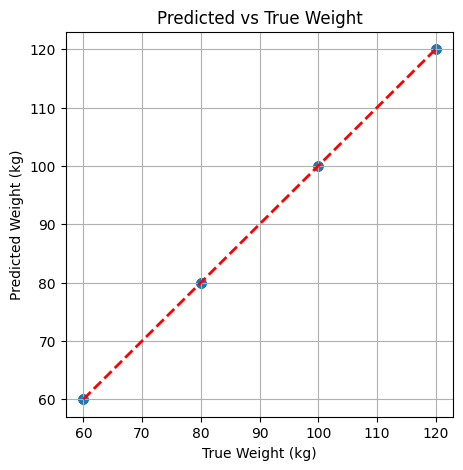

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=40)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("True Weight (kg)")
plt.ylabel("Predicted Weight (kg)")
plt.title("Predicted vs True Weight")
plt.grid(True)
plt.show()
